Клонирование yolo v5, установка зависимостей

In [1]:
!pip install wandb
!pip install pybboxes 
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c6aafab9cc28b6a0013011fbe3550e725923e5829be9c5da9e06957589dd0c05
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Total 15305 (delta 0), reused 0 (delta 0), pack-reused 15305
Receiving obj

In [ ]:
! unzip /content/archive.zip -d /content

тест предобученной модели

In [4]:
! python detect.py --weights yolov5s.pt --source /content/data/testing_images/vid_5_25100.jpg --exist-ok #пусто
! python detect.py --weights yolov5s.pt --source /content/data/testing_images/vid_5_26600.jpg --exist-ok #кусок машины
! python detect.py --weights yolov5s.pt --source /content/data/testing_images/vid_5_30820.jpg --exist-ok #несколько машин

detect: weights=['yolov5s.pt'], source=/content/data/testing_images/vid_5_25100.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 168MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 20.6ms
Speed: 0.6ms pre-process, 20.6ms inference, 22.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp
detect: weights=['yolov5s.pt'], source=/content/data/testing_images/vid_5_26600.jpg, data=data/coco1

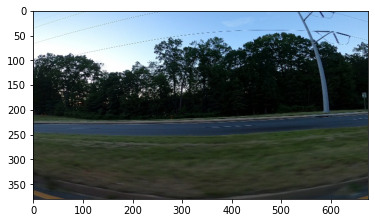

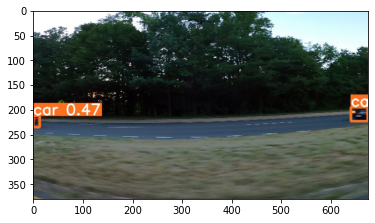

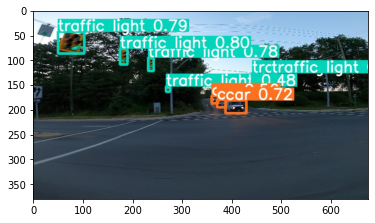

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(plt.imread('/content/yolov5/runs/detect/exp/vid_5_25100.jpg'));
plt.figure()
plt.imshow(plt.imread('/content/yolov5/runs/detect/exp/vid_5_26600.jpg'));
plt.figure()
plt.imshow(plt.imread('/content/yolov5/runs/detect/exp/vid_5_30820.jpg'));

In [6]:
import os

import yaml
import cv2
import numpy as np
import shutil
import pandas as pd
import pybboxes as pbx
from tqdm import tqdm

DATA_PATH = '/content/data/training_images'
TRAIN_DATA_PATH = '/content/dataset'

df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')

name2shape = {}

for image_name in tqdm(df.image.unique()):
    image = plt.imread(os.path.join(DATA_PATH, image_name))
    name2shape[image_name] = image.shape

set(list(name2shape.values()))

100%|██████████| 355/355 [00:02<00:00, 126.25it/s]


{(380, 676, 3)}

In [7]:
X = 676
Y = 380

def recalculate(row):
    s = []
    s.append(0)
    s.append(((row.xmax + row.xmin) / 2) / X)
    s.append(((row.ymax + row.ymin) / 2) / Y)
    s.append((row.xmax - row.xmin) / X)
    s.append((row.ymax - row.ymin) / Y)
    return ' '.join(map(str, s))

Проверим правильность преобразования

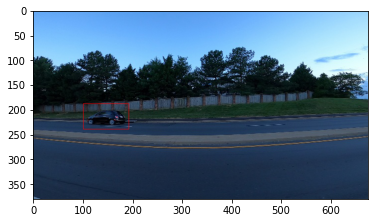

In [8]:
test_loc = 120

yolo_normalized = tuple(map(float, recalculate(df.iloc[test_loc]).split(' ')[1:]))

H, W = (380, 676,)

box_voc = pbx.convert_bbox(yolo_normalized, from_type='yolo', to_type='voc', image_size=(W, H))

img = plt.imread(os.path.join(DATA_PATH, df.iloc[test_loc].image))

cv2.rectangle(img, (box_voc[0], box_voc[1]), (box_voc[2], box_voc[3]), (255, 0, 0), 1)
plt.figure()
plt.imshow(img)
plt.show()

In [9]:
df.image.nunique()

355

In [10]:
! mkdir /content/dataset
! mkdir /content/dataset/images
! mkdir /content/dataset/labels
! mkdir /content/dataset/images/train
! mkdir /content/dataset/images/val
! mkdir /content/dataset/labels/train
! mkdir /content/dataset/labels/val

In [11]:
train_imgs = np.random.choice(df.image.unique(), size=255)
val_imgs = df[~df.image.isin(train_imgs)].image.unique()

for file_name in train_imgs:
    full_file_name = os.path.join(DATA_PATH, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, os.path.join(TRAIN_DATA_PATH, 'images', 'train'))


for file_name in val_imgs:
    full_file_name = os.path.join(DATA_PATH, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, os.path.join(TRAIN_DATA_PATH, 'images', 'val'))


for image_name in train_imgs:
    with open(os.path.join(TRAIN_DATA_PATH, 'labels', 'train', f'{image_name[:-4]}.txt'), 'w') as f:
        for row in df[df.image == image_name].iterrows():
            f.write(recalculate(row[1]))


for image_name in val_imgs:
    with open(os.path.join(TRAIN_DATA_PATH, 'labels', 'val', f'{image_name[:-4]}.txt'), 'w') as f:
        for row in df[df.image == image_name].iterrows():
            f.write(recalculate(row[1]))

In [12]:
to_yaml = {
  'path': TRAIN_DATA_PATH,
  'train': 'images/train',
  'val': 'images/val',
  'names': {0: 'car'},
}

with open(os.path.join(TRAIN_DATA_PATH, 'custom.yaml'), 'w+') as f:
    yaml.dump(to_yaml, f, allow_unicode=True)

Обучение модели

In [15]:
!  python train.py --exist-ok --freeze 10 --img 640 --batch 4 --epochs 200 --data /content/dataset/custom.yaml --weights yolov5s.pt --seed 165 --project /content/dataset

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov5s.pt, cfg=, data=/content/dataset/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, mu

экспорт обученной модели в форматы onnx tflite

In [16]:
! python export.py --img 640 --weights /content/dataset/exp/weights/best.pt --include onnx tflite

export: data=data/coco128.yaml, weights=['/content/dataset/exp/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx', 'tflite']
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/dataset/exp/weights/best.pt with output shape (1, 25200, 6) (13.7 MB)

ONNX: starting export with onnx 1.13.1...
ONNX: export success ✅ 1.0s, saved as /content/dataset/exp/weights/best.onnx (27.2 MB)
2023-03-18 07:12:15.874703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

инференс обученной модели

In [17]:
! python detect.py --exist-ok --img 640 --weights /content/dataset/exp/weights/best.onnx --source /content/data/testing_images/vid_5_25100.jpg --project /content/dataset/runs #пусто
! python detect.py --exist-ok --img 640 --weights /content/dataset/exp/weights/best.onnx --source /content/data/testing_images/vid_5_26600.jpg --project /content/dataset/runs #кусок машины
! python detect.py --exist-ok --img 640 --weights /content/dataset/exp/weights/best.onnx --source /content/data/testing_images/vid_5_30820.jpg --project /content/dataset/runs #несколько машин

detect: weights=['/content/dataset/exp/weights/best.onnx'], source=/content/data/testing_images/vid_5_25100.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/dataset/runs, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Loading /content/dataset/exp/weights/best.onnx for ONNX Runtime inference...
requirements: YOLOv5 requirement "onnxruntime-gpu" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0

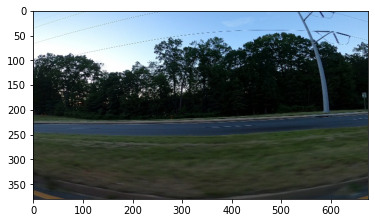

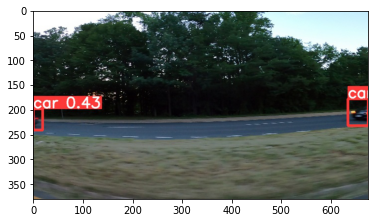

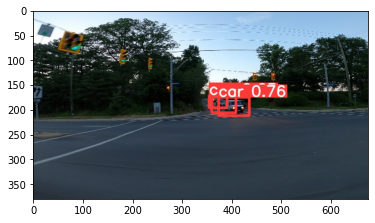

In [18]:
plt.figure()
plt.imshow(plt.imread('/content/dataset/runs/exp/vid_5_25100.jpg'));
plt.figure()
plt.imshow(plt.imread('/content/dataset/runs/exp/vid_5_26600.jpg'));
plt.figure()
plt.imshow(plt.imread('/content/dataset/runs/exp/vid_5_30820.jpg'));